In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import calendar
from datetime import datetime

from nltk.sentiment.vader import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import copy

# eg. "December 31, 2017"  ---->  "2017-12-31"
def str2date(s):
    sl = s.split(" ")
    sl[0] = str(list(calendar.month_name).index(sl[0]))
    sl[1] = sl[1].strip(",")
    sld = "{0}-{1}-{2}".format(sl[2], sl[0], sl[1])
    return sld

# Read from csv file
def get_df(path):
    df = pd.read_csv(path)
    df['date'] = df['date'].map(str2date)
    df['date'] = df['date'].astype('datetime64[ns]')         # type
    df['year'] = df['date'].dt.year
    df['year_month'] = df['date'].apply(lambda x: x.strftime('%Y-%m'))
    df.sort_values(by="date", inplace=True, ascending=True) # Sort by the dates
    return df

# Emotional analysis
# negative neutral positive compound
def emotion_analysis(text_list):
    sid = SentimentIntensityAnalyzer()
    result = []
    temp = 0
    for sen in text_list:
        senti = sid.polarity_scores(sen)   # text
        result.append(senti)
    return result

## call emotion_analysis(text)
def get_title_text_emo(path):
    df = get_df(path)
    texts_emo = emotion_analysis(df['text'])
    df['text_emo'] = [e['compound'] for e in texts_emo]
    titles_emo = emotion_analysis(df['title'])
    df['title_emo'] = [e['compound'] for e in titles_emo]
    ## label text
    df['text_label'] = 'neu'
    df.loc[df['text_emo']>0.33, 'text_label'] = 'pos'
    df.loc[df['text_emo']<-0.33, 'text_label'] = 'neg'
    ## label title
    df['title_label'] = 'neu'
    df.loc[df['title_emo']>0.33, 'title_label'] = 'pos'
    df.loc[df['title_emo']<-0.33, 'title_label'] = 'neg'
    return df

def plot_emo_df(input_df, interv=1):
    input_df = copy.deepcopy(input_df)
    df_mean = input_df.groupby(["date"], as_index=False)[["text_emo", "title_emo"]].apply(np.mean)
    df_mean.plot(x='date', y=['text_emo', 'title_emo'], ylabel="Emotional score", kind='line', figsize=(15,10), subplots=True)
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=interv))  # per month
    plt.show()

## colomn_name: 'text_label'  or  'title_label'
def plot_by_year_month(input_df, label_name):
    input_df = copy.deepcopy(input_df)
    df_year_month = input_df.groupby(["year_month", label_name], as_index=False)[[label_name]].size()
    from collections import defaultdict
    res_y_m = defaultdict(dict)
    for idx,row in df_year_month.iterrows():
        res_y_m[row[label_name]][row['year_month']]=row['size']  # eg.'text_label'  or  'title_label'
    df_y_m = pd.DataFrame(res_y_m)
    for idx,row in df_y_m.iterrows():
        col_sum = np.sum(row.values)
        for k in row.keys():
            df_y_m.loc[idx, k] = round(df_y_m.loc[idx, k]/col_sum, 3)
    df_y_m.plot(kind='bar',xlabel="Date", ylabel="Emotional ratio", figsize=(16,8))
    plt.title(label_name)
    return df_y_m
                
## colomn_name: 'text_label'  or  'title_label'
def plot_by_year(input_df, label_name):
    input_df = copy.deepcopy(input_df)
    df_year = input_df.groupby(["year", label_name], as_index=False)[[label_name]].size()
    from collections import defaultdict
    res_y = defaultdict(dict)
    for idx,row in df_year.iterrows():
        res_y[row['year']][row[label_name]]=row['size']  # eg.'text_label'  or  'title_label'
    df_y = pd.DataFrame(res_y)
    for idx,col in df_y.iteritems():
        col_sum = sum(col)
        for k in col.keys():
            df_y.loc[k, idx] = round(df_y.loc[k, idx]/col_sum,3)
    df_y.plot(kind='pie',figsize=(16,8), subplots=True, title='Emotional ratio in different years, ' + label_name)
    return df_y


In [1]:
path_true ="kaggle/True.csv"
path_fake = "kaggle/Fake.csv"

In [3]:
%%time
df_true = get_title_text_emo(path_true)

CPU times: user 1min 3s, sys: 308 ms, total: 1min 4s
Wall time: 1min 4s


In [4]:
df_true.tail()

,title,text,subject,date,year,year_month,text_emo,title_emo,text_label,title_label
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,2017-12-29,2017,2017-12,0.5896,0.2449,pos,neu
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,2017-12-29,2017,2017-12,-0.0547,0.3818,neu,pos
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,2017-12-30,2017,2017-12,-0.2201,0.0000,neu,neu
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,2017-12-31,2017,2017-12,-0.6808,0.0000,neg,neu
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,2017-12-31,2017,2017-12,0.9857,-0.4939,pos,neg


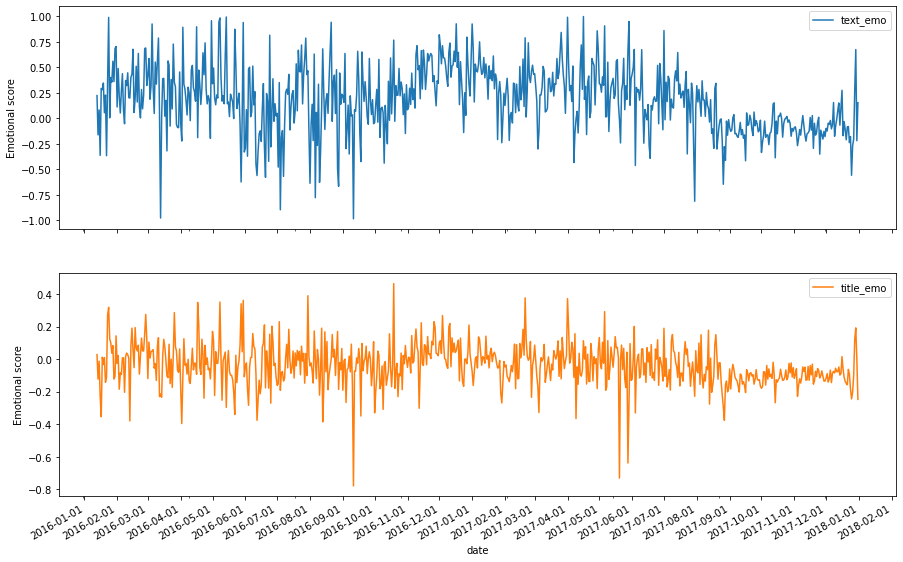

In [5]:
plot_emo_df(df_true, 1)

,neg,neu,pos
2016-01,0.341,0.085,0.573
2016-02,0.310,0.090,0.600
2016-03,0.300,0.078,0.622
2016-04,0.303,0.089,0.608
2016-05,0.343,0.119,0.538
2016-06,0.446,0.091,0.463
2016-07,0.358,0.077,0.565
2016-08,0.377,0.125,0.498
2016-09,0.353,0.108,0.538
2016-10,0.369,0.086,0.545


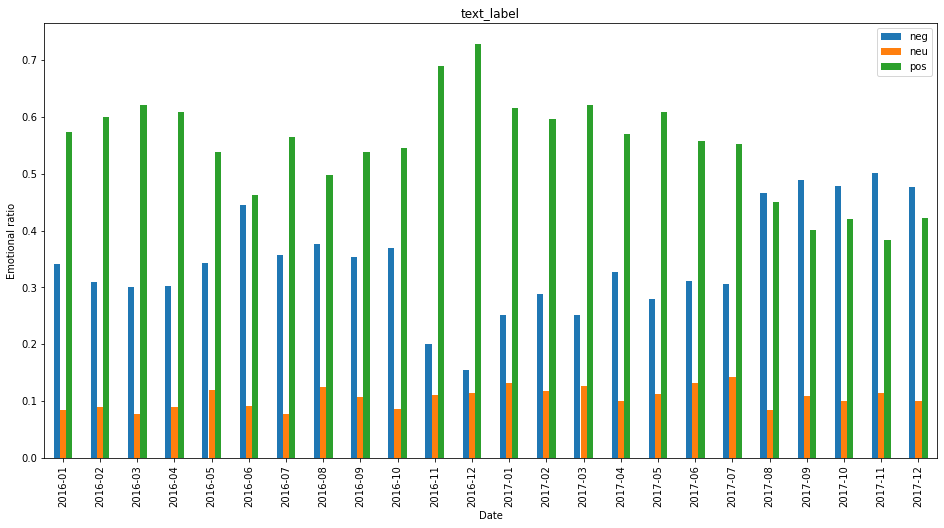

In [20]:
plot_by_year_month(df_true, 'text_label')

,neg,neu,pos
2016-01,0.183,0.654,0.163
2016-02,0.190,0.567,0.243
2016-03,0.192,0.598,0.210
2016-04,0.201,0.616,0.183
2016-05,0.221,0.589,0.190
2016-06,0.255,0.580,0.165
2016-07,0.213,0.633,0.154
2016-08,0.204,0.619,0.177
2016-09,0.211,0.630,0.160
2016-10,0.250,0.616,0.134


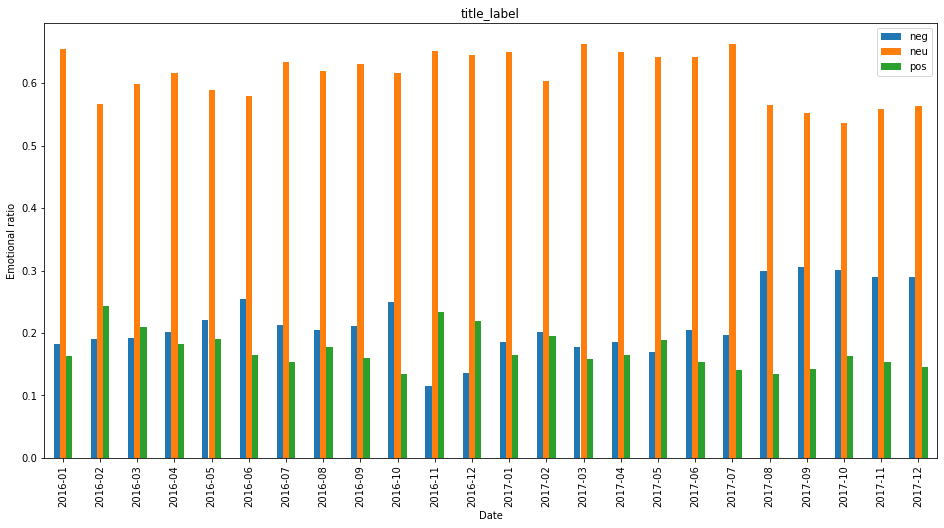

In [21]:
plot_by_year_month(df_true, 'title_label')

,2016,2017
neg,0.311,0.436
neu,0.098,0.110
pos,0.591,0.454


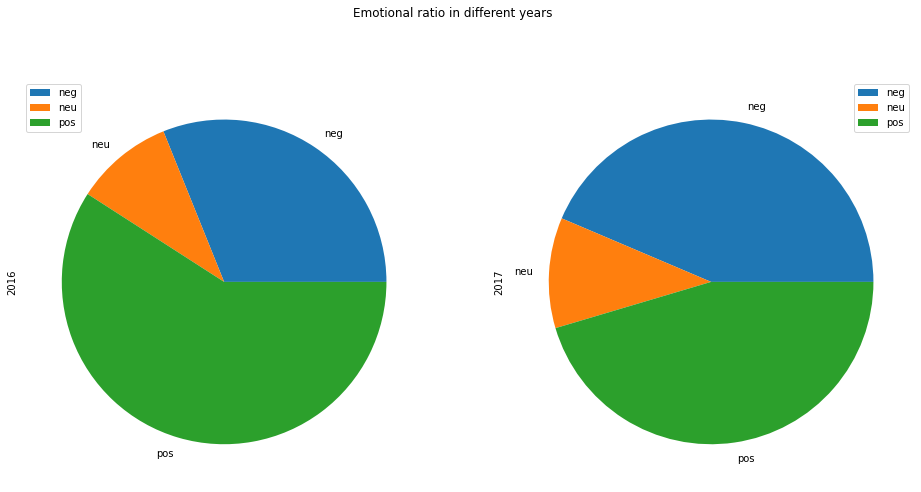

In [8]:
plot_by_year(df_true, 'text_label')

/opt/anaconda3/lib/python3.9/site-packages/pandas/plotting/_matplotlib/core.py:1616: MatplotlibDeprecationWarning: normalize=None does not normalize if the sum is less than 1 but this behavior is deprecated since 3.3 until two minor releases later. After the deprecation period the default value will be normalize=True. To prevent normalization pass normalize=False 
  results = ax.pie(y, labels=blabels, **kwds)


,2016,2017
neg,0.192,0.270
neu,0.616,0.576
pos,0.192,0.154


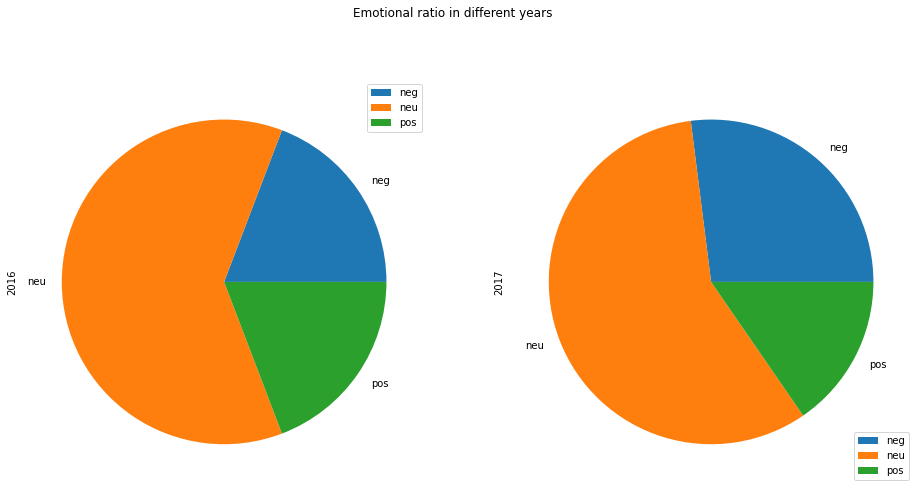

In [10]:
plot_by_year(df_true, 'title_label')

In [11]:
# eg. "December 31, 2017"  ---->  "2017-12-31"
def str2date_fake(s):
    sld = ""
    sl = s.split('-')
    if len(sl) == 3:
#         print(len(sl), sl)
        sl[1] = list(calendar.month_abbr).index(sl[1])
        sld = "20{0}-{1}-{2}".format(sl[2], sl[1], sl[0])
    else:
        sl = s.split(" ")
        if len(sl) != 3:
#             print(sl)
            return ""
        if sl[0] in list(calendar.month_name):
            sl[0] = str(list(calendar.month_name).index(sl[0]))
        elif sl[0] in list(calendar.month_abbr):
            sl[0] = str(list(calendar.month_abbr).index(sl[0]))
        sl[1] = sl[1].strip(",")
        sld = "{0}-{1}-{2}".format(sl[2], sl[0], sl[1])
    return sld

# Read from csv file
def get_df_fake(path):
    df = pd.read_csv(path)
    del_idx = []
    for i in range(len(df['date'])):
        s = df.loc[i, 'date']
        ss = str2date_fake(s)
        if ss=="":
            del_idx.append(i)
        df.loc[i, 'date']=ss
    df.drop(del_idx)
    df.dropna(axis=0,how='any')
    df['date']=pd.to_datetime(df['date'], errors='coerce', format='%Y-%m-%d')
    df['year'] = df['date'].dt.year
    df['year_month'] = pd.to_datetime(df['date'], errors='coerce', format='%Y')
    df.sort_values(by="date", inplace=True, ascending=True) # Sort by the dates
    df.dropna(axis=0,how='any')
    return df

## call emotion_analysis(text)
def get_title_text_emo_fake(path):
    df = get_df_fake(path)
    texts_emo = emotion_analysis(df['text'])
    df['text_emo'] = [e['compound'] for e in texts_emo]
    titles_emo = emotion_analysis(df['title'])
    df['title_emo'] = [e['compound'] for e in titles_emo]
    ## label text
    df['text_label'] = 'neu'
    df.loc[df['text_emo']>0.33, 'text_label'] = 'pos'
    df.loc[df['text_emo']<-0.33, 'text_label'] = 'neg'
    ## label title
    df['title_label'] = 'neu'
    df.loc[df['title_emo']>0.33, 'title_label'] = 'pos'
    df.loc[df['title_emo']<-0.33, 'title_label'] = 'neg'
    return df

In [12]:
df_fake = get_df_fake(path_fake)
df_fake.head()

,title,text,subject,date,year,year_month
21919,HILLARY RODHAM NIXON: A CANDIDATE WITH MORE BA...,The irony here isn t lost on us. Hillary is be...,left-news,2015-03-31,2015.0,2015-03-31
15886,APPLE’S CEO SAYS RELIGIOUS FREEDOM LAWS ARE ‘D...,The gay mafia has a new corporate Don. This i...,politics,2015-03-31,2015.0,2015-03-31
15887,WATCH DIRTY HARRY REID ON HIS LIE ABOUT ROMNEY...,"In case you missed it Sen. Harry Reid (R-NV), ...",politics,2015-03-31,2015.0,2015-03-31
15888,OH NO! GUESS WHO FUNDED THE SHRINE TO TED KENNEDY,Nothing like political cronyism to make your s...,politics,2015-03-31,2015.0,2015-03-31
15889,BENGHAZI PANEL CALLS HILLARY TO TESTIFY UNDER ...,Does anyone really think Hillary Clinton will ...,politics,2015-03-31,2015.0,2015-03-31


In [13]:
df_fake.tail()

,title,text,subject,date,year,year_month
17432,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,Government News,NaT,NaN,NaT
17433,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,Government News,NaT,NaN,NaT
18933,Homepage,[vc_row][vc_column width= 1/1 ][td_block_trend...,left-news,NaT,NaN,NaT
21869,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,left-news,NaT,NaN,NaT
21870,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,left-news,NaT,NaN,NaT


In [14]:
df_fake=get_title_text_emo_fake(path_fake)

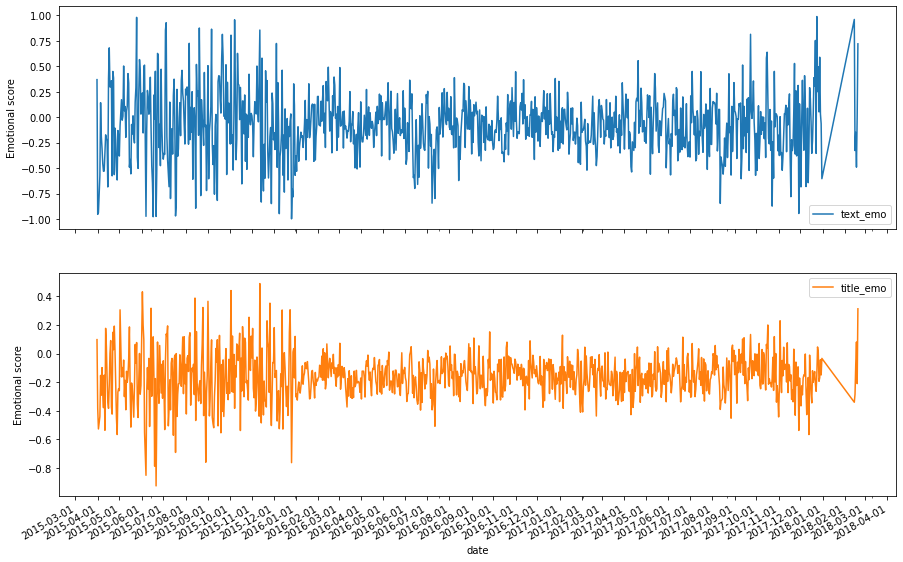

In [15]:
plot_emo_df(df_fake, 1)

,neg,neu,pos
2015-03-31,0.25,0.125,0.625
2015-04-01,NaN,NaN,NaN
2015-04-02,NaN,NaN,NaN
2015-04-04,NaN,NaN,NaN
2015-04-05,NaN,NaN,NaN
...,...,...,...
2015-10-08,NaN,NaN,NaN
2015-11-12,NaN,NaN,NaN
2015-12-05,NaN,NaN,NaN
2017-12-24,NaN,NaN,NaN


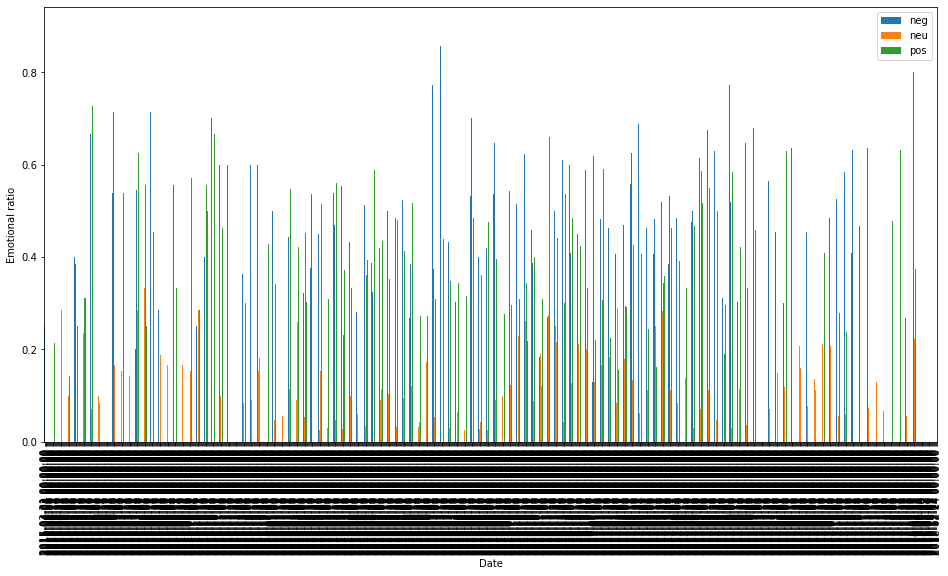

In [18]:
plot_by_year_month(df_fake, 'text_label')

/opt/anaconda3/lib/python3.9/site-packages/pandas/plotting/_matplotlib/core.py:1616: MatplotlibDeprecationWarning: normalize=None does not normalize if the sum is less than 1 but this behavior is deprecated since 3.3 until two minor releases later. After the deprecation period the default value will be normalize=True. To prevent normalization pass normalize=False 
  results = ax.pie(y, labels=blabels, **kwds)


,2015.0,2016.0,2017.0,2018.0
neg,0.405,0.418,0.419,0.343
neu,0.417,0.391,0.396,0.457
pos,0.178,0.191,0.186,0.200


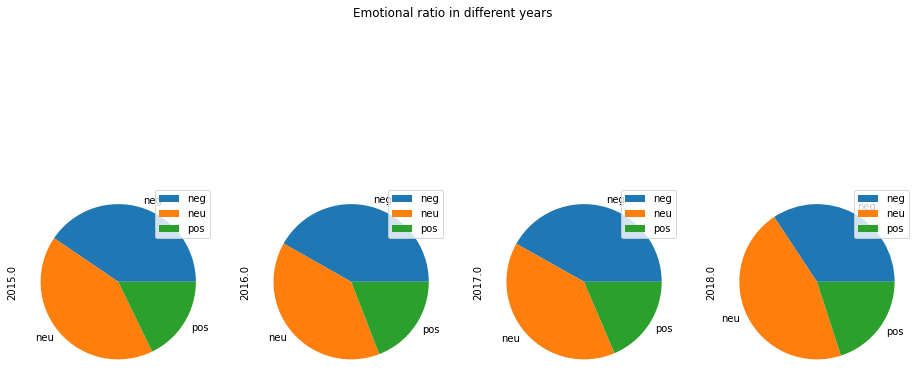

In [17]:
plot_by_year(df_fake, 'title_label')